In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

## Example Network using QAOA ##

![Screenshot%202023-04-13%20231103.jpg](attachment:Screenshot%202023-04-13%20231103.jpg)


<br>
First we have to create the problem Hamiltonian in the Ising model and add a mixer Hamiltonian for optimizing using QAOA. To generate the Hamiltonian, we use the QUBO method, used in various other combinatorial problems.

In [2]:
!pip install pyqubo
from pyqubo import Array,Constraint,Placeholder
from matplotlib import pyplot as plt
import networkx as nx

  Using cached pyqubo-1.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (245 kB)
  Using cached dimod-0.12.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached dwave_neal-0.6.0-py3-none-any.whl (8.7 kB)
  Using cached wrapt-1.15.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (78 kB)
  Using cached dwave_samplers-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.1 MB)

[notice] A new release of pip available: 23.1.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
#from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
#from qiskit.aqua.operators import op_converter
#from qiskit.aqua.operators import WeightedPauliOperator
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

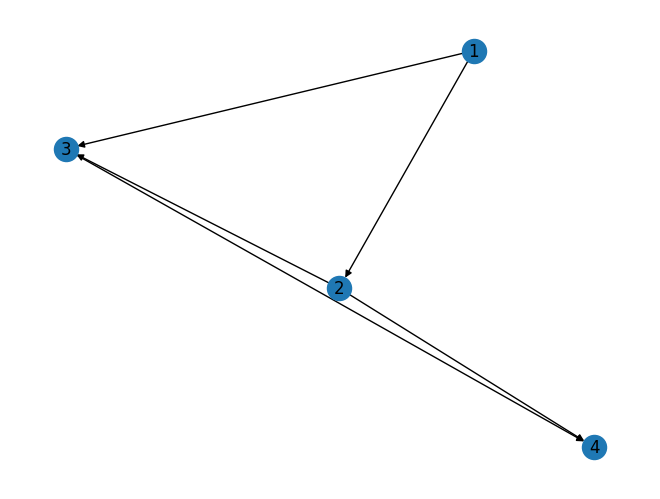

2 [1, 2, 4]


In [4]:
edges = [(1,2),(1,3),(2,3),(2,4),(3,4)]
weights = [5,8,2,7,4] 

x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') #SPIN

G = nx.DiGraph(edges)
nx.draw(G, with_labels=True)
plt.show()

C = nx.shortest_path_length(G, source=1, target=4, weight='weights')
S = nx.shortest_path(G, source=1, target=4, weight='weights')
print(C,S)

In [5]:
print(x.shape)
print(x)
y = (4*x[0]+x[1])
print(y)

(5,)
Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]')])
((4.000000 * Binary('x[0]')) + Binary('x[1]'))


In [6]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied

## Constraints ##
fcost += p*((x[0] + x[1] - 1)**2) 
fcost += p*((x[0] - x[2] - x[3])**2)
fcost += p*((x[1] + x[2] - x[4])**2)

model = fcost.compile()
print(model.to_qubo())

({('x[3]', 'x[3]'): 34.0, ('x[2]', 'x[0]'): -54.0, ('x[2]', 'x[2]'): 56.0, ('x[4]', 'x[4]'): 31.0, ('x[1]', 'x[1]'): 8.0, ('x[4]', 'x[1]'): -54.0, ('x[1]', 'x[2]'): 54.0, ('x[1]', 'x[0]'): 54.0, ('x[4]', 'x[2]'): -54.0, ('x[2]', 'x[3]'): 54.0, ('x[3]', 'x[0]'): -54.0, ('x[0]', 'x[0]'): 5.0}, 27.0)


In [7]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[3]': 17.0, 'x[4]': -11.5, 'x[2]': 28.0, 'x[1]': 17.5, 'x[0]': -11.0}
Quadratic Coefficients {('x[2]', 'x[3]'): 13.5, ('x[1]', 'x[4]'): -13.5, ('x[2]', 'x[4]'): -13.5, ('x[1]', 'x[2]'): 13.5, ('x[0]', 'x[3]'): -13.5, ('x[0]', 'x[2]'): -13.5, ('x[0]', 'x[1]'): 13.5}


<br>
This Objective function ultimately corresponds to the following circuit:

<img src="qaoa.png">

In [8]:
def get_cost_operator_circuit(gamma):
    N = len(edges)
    qc = QuantumCircuit(N,N)
    for i in range(N):
        linear_coeff = linear.get('x['+str(i)+']')
        qc.rz(-1*linear_coeff,i)
    for i in range(len(quadratic)):
        q1 = int(list(quadratic.keys())[i][0][2])
        q2 = int(list(quadratic.keys())[i][1][2])
        quadratic_coeff = quadratic.get(('x['+str(q1)+']', 'x['+str(q2)+']'))
        qc.cx(q1,q2)
        qc.rz(2*gamma, q2)
        qc.cx(q1,q2)
    return qc

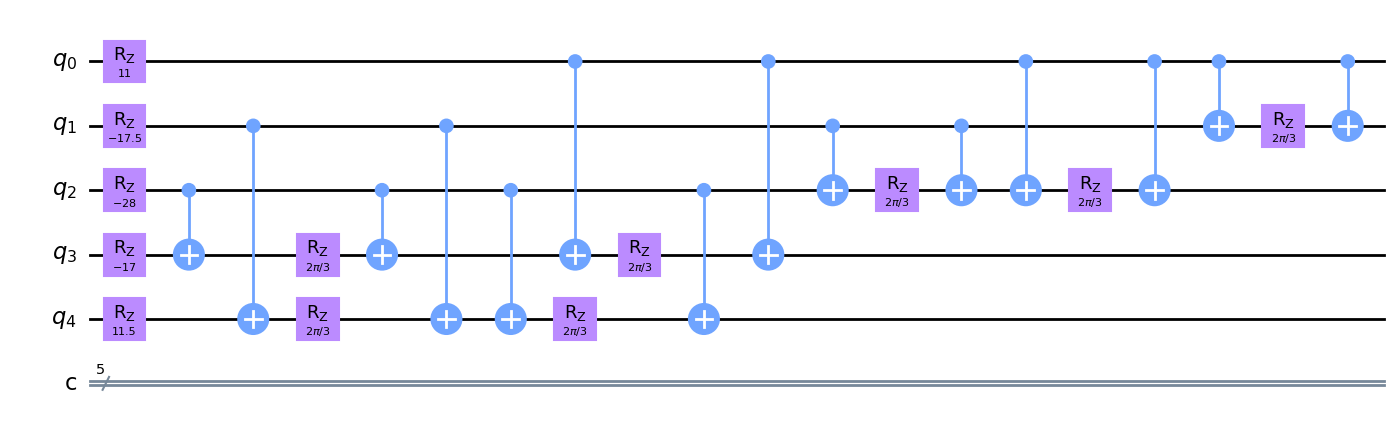

In [9]:
qc = get_cost_operator_circuit(np.pi / 3)
qc.draw()

In [10]:
def get_mixer_operator_circuit(beta):
    N = len(edges)
    qc = QuantumCircuit(N,N)
    for i in range(N):
        qc.rx(2*beta,i)
    return qc

In [11]:
def get_qaoa_circuit(beta, gamma):
    N = len(edges)
    qc = QuantumCircuit(N,N)
    for i in range(N):
        qc.h(i)
    qc.barrier()
    for i in range(N):
        linear_coeff = linear.get('x['+str(i)+']')
        qc.rz(-1*linear_coeff,i)
    qc.barrier()
    for i in range(len(quadratic)):
        q1 = int(list(quadratic.keys())[i][0][2])
        q2 = int(list(quadratic.keys())[i][1][2])
        quadratic_coeff = quadratic.get(('x['+str(q1)+']', 'x['+str(q2)+']'))
        qc.cx(q1,q2)
        qc.rz(2*gamma, q2)
        qc.cx(q1,q2)
    qc.barrier()
    for i in range(N):
        qc.rx(2*beta,i)
    qc.measure(range(N), range(N))
    return qc

In [12]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    backend = Aer.get_backend('qasm_simulator')
    
    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]
    
    circuit = get_qaoa_circuit(beta, gamma)
    
    shots = 1024
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    
    return compute_expectation(counts, shots)

In [13]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):
    
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= 1024
    #print(expectation)
    return expectation

In [14]:
## Classical Optimizer ##

from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,
               [1.0, 1.0],
               method='SLSQP') # COBYLA
print(res)

     fun: 13.8173828125
     jac: array([27983872., 24117248.])
 message: 'Optimization terminated successfully'
    nfev: 157
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 15619.86804766, -28236.83582403])


{'01101': 1, '10110': 107, '01111': 67, '10010': 98, '10101': 24, '11100': 29, '00011': 15, '00111': 25, '00001': 29, '00110': 62, '10000': 58, '01110': 20, '10001': 43, '11010': 34, '01001': 3, '00101': 2, '00000': 55, '11000': 25, '11011': 18, '11111': 30, '10011': 46, '10111': 22, '10100': 40, '00010': 43, '11110': 35, '11101': 39, '01000': 38, '01100': 4, '00100': 10, '01010': 2}


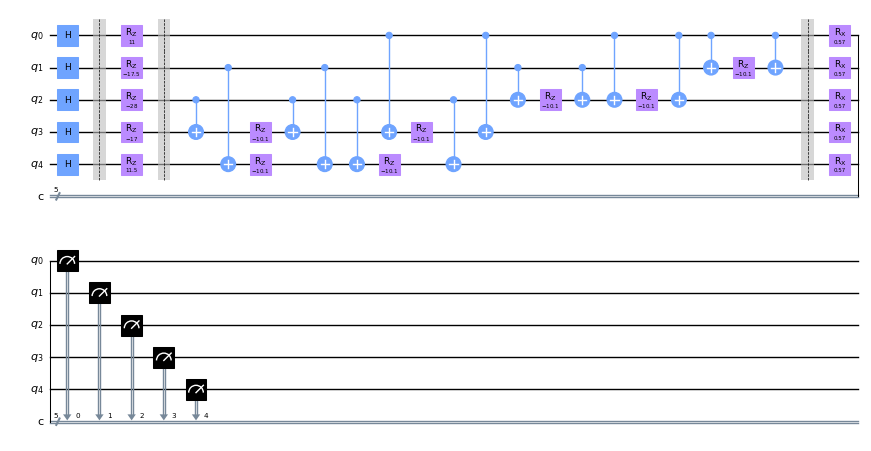

In [28]:
#beta = res.get('x')[0]
#gamma = res.get('x')[1]
circuit = get_qaoa_circuit(0.28517317, -5.05969577)

backend = Aer.get_backend('qasm_simulator')

shots = 1024
result = execute(circuit, backend, shots=shots).result()
counts = result.get_counts()
print(counts)

len(counts.keys())

circuit.draw('mpl', scale = 0.5)
#circuit.draw("mpl").savefig('qaoa_qubit_5_circuit.png')
# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')